In [1]:
from client.model import compile_model, save_parameters, load_parameters
from client.startup import MyClient, prepare_data
from client.data import load_data
from server_functions import ServerFunctions
from scaleout.client.edge_client import EdgeClient
import torch
import matplotlib.pyplot as plt
import numpy as np


#get_data('C:/Users/maxha/OneDrive - RISE/Documents/FEDn/scaleout-client-python/examples/server-functions/max_data')
model = compile_model()
print(model)

N_clients = 2
edge = EdgeClient()
clients = dict()
clients = [MyClient(edge) for _ in range(N_clients)]
#prepare_data()




2026-02-13 10:34:35 [DEBUG] Token cache initialized at: C:\Users\maxha\.scaleout\tokens\api-client.json
ConvNeXt(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
      (1): LayerNorm2d((96,), eps=1e-06, elementwise_affine=True)
    )
    (1): Sequential(
      (0): CNBlock(
        (block): Sequential(
          (0): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
          (1): Permute()
          (2): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
          (3): Linear(in_features=96, out_features=384, bias=True)
          (4): GELU(approximate='none')
          (5): Linear(in_features=384, out_features=96, bias=True)
          (6): Permute()
        )
        (stochastic_depth): StochasticDepth(p=0.0, mode=row)
      )
      (1): CNBlock(
        (block): Sequential(
          (0): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
          (1): Permute(

Dataset Imagenette
    Number of datapoints: 9469
    Root location: C:/Users/maxha/OneDrive - RISE/Documents/FEDn/scaleout-client-python/examples/Max-Imagenette/max_data/
    StandardTransform
Transform: ImageClassification(
               crop_size=[224]
               resize_size=[236]
               mean=[0.485, 0.456, 0.406]
               std=[0.229, 0.224, 0.225]
               interpolation=InterpolationMode.BILINEAR
           )
torch.Size([3, 224, 224])
klar inläsning


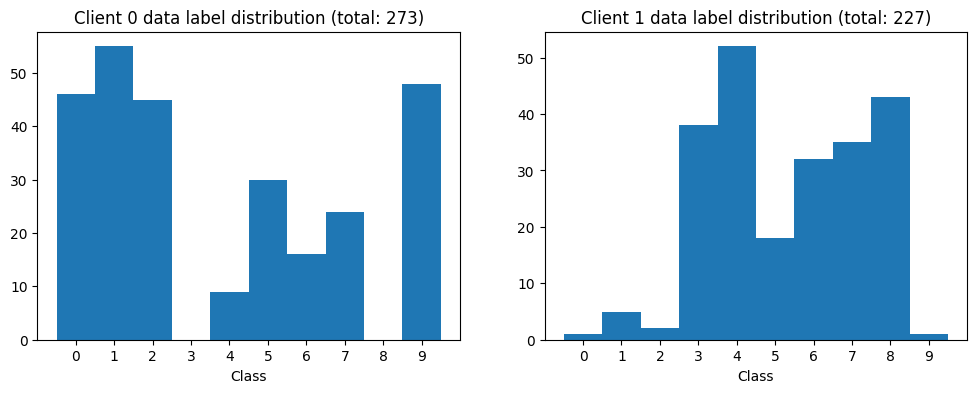

In [2]:
import pickle
import torchvision
from torchvision import transforms, datasets
def niid_loader(data_path=None, is_train=True, idx_dict_path=None, dataset_name='mnist', indices_path=None):
    with open(idx_dict_path, 'rb') as f:
        idx_dict = pickle.load(f)

    
    if data_path == None:
        print('No data path given!')
        return
        
    elif idx_dict == None:
        print('No dictionary for mapping non-iid datadata to clients!')
        return
    
    #Imagenette för convnext
    if dataset_name == 'imagenette':
        data = load_data(data_path=data_path, is_train=is_train)
        print(data)
        print(data[0][0].shape)

        with open(indices_path, 'rb') as f:
            indices_map = pickle.load(f)

        client_ds = [
            torch.utils.data.Subset(data, indices_map[indices])
            for key, indices in idx_dict.items()
            ]
        
            
    #MNIST
    elif dataset_name == 'mnist':
        data = datasets.MNIST(
            root=data_path, 
            train=is_train,
            download=False,
            transform=transforms.Compose([
                transforms.ToTensor()
            ])
        )

        client_ds = [
            torch.utils.data.Subset(data, indices)
            for key, indices in idx_dict.items()
            ]
   

    return client_ds

# client_ds = niid_loader(
#     data_path='C:/Users/maxha/OneDrive - RISE/Documents/FEDn/scaleout-client-python/examples/server-functions/max_data/', 
#     is_train=True, 
#     idx_dict_path='C:/Users/maxha/OneDrive - RISE/Documents/NIID-Bench/max_dataidx_maps/net_dataidx_map_labeldir_beta05.pkl',
#     )

client_ds = niid_loader(
    data_path='C:/Users/maxha/OneDrive - RISE/Documents/FEDn/scaleout-client-python/examples/Max-Imagenette/max_data/', 
    is_train=True, 
    idx_dict_path='C:/Users/maxha/OneDrive - RISE/Documents/NIID-Bench/max_dataidx_maps/imagenette_500samples_dataidx_map_labeldir_beta05.pkl', #'C:/Users/maxha/OneDrive - RISE/Documents/NIID-Bench/max_partitions/net_dataidx_map_labeldir_beta05.pkl',
    dataset_name='imagenette',
    indices_path='C:/Users/maxha/OneDrive - RISE/Documents/NIID-Bench/max_dataidx_maps/imagenette_indices.pkl'
    )
print('klar inläsning')
labels = [[] for _ in range(N_clients)]
for c in range(N_clients):
    for _, label in client_ds[c]:
        labels[c].append(label)
#Client data distribution
fig, axs = plt.subplots(1,N_clients, figsize=(12,4))
for i, client_labels in enumerate(labels):
    axs[i].hist(client_labels, bins=np.arange(11)-0.5)
    axs[i].set_title(f'Client {i} data label distribution (total: {len(client_labels)})')
    axs[i].set_xlabel('Class')
    axs[i].set_xticks(np.arange(10))
plt.show()

In [3]:
from copy import deepcopy
from scaleoututil.serverfunctions.serverfunctionsbase import RoundType
from scaleoututil.utils.model import ScaleoutModel
from collections import defaultdict


#initialize global params
global_params = save_parameters(model)


client_ids = [i for i in range(N_clients)]
server_functions = ServerFunctions()
client_dl = [torch.utils.data.DataLoader(
    dataset=ds,
    batch_size=4,
    ) 
    for ds in client_ds
    ]
metrics_list = defaultdict(lambda: defaultdict(list))


#for .. (this is one FL round)
for round in range(2):
    selected = server_functions.client_selection(client_ids, RoundType.TRAINING) 
    settings = server_functions.client_settings(global_params) #Transform to list

    params_list = dict()
    losses = []
    for id in client_ids:
        #Olika datapartitioner på olika clients
        params, metadata, metrics = clients[id].train(
            scaleout_model=global_params, 
            settings=settings,
            #data_path=f'max_data/mnist_clients/client_{id}.pt'
            data_loader = client_dl[id]
            )
        params_list[id] =(params.get_model_params(), metadata)

        metrics_list[id]['training_loss'].append(metrics['training_loss'])
        metrics_list[id]['training_accuracy'].append(metrics['training_accuracy'])

    #Aggregate
    new_params = server_functions.aggregate(global_params.get_model_params(), params_list)
    global_params = global_params.from_model_params(new_params)



Epoch 0/0 | Batch 0/68 | Loss: 2.1759
2026-02-13 10:35:18 [ERROR] Missing context for logging metric.
Epoch 0 finished | Loss: 0.9494 | Acc: 0.8901
Epoch 0/0 | Batch 0/56 | Loss: 2.3073
2026-02-13 10:35:44 [ERROR] Missing context for logging metric.
Epoch 0 finished | Loss: 1.0355 | Acc: 0.8546
Models aggregated
Epoch 0/0 | Batch 0/68 | Loss: 0.6150
2026-02-13 10:36:46 [ERROR] Missing context for logging metric.
Epoch 0 finished | Loss: 0.3605 | Acc: 0.9963
Epoch 0/0 | Batch 0/56 | Loss: 0.6410
2026-02-13 10:37:15 [ERROR] Missing context for logging metric.
Epoch 0 finished | Loss: 0.4041 | Acc: 0.9868
Models aggregated


In [9]:
print(150528/(784*64))

3.0


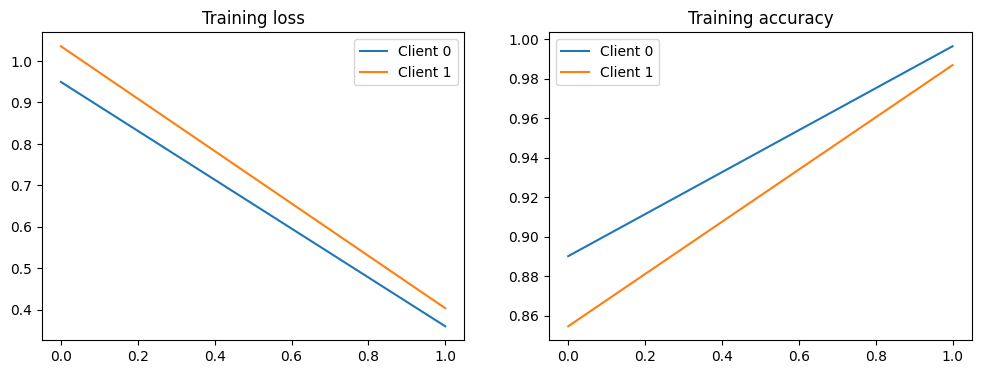

In [4]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,4))
for id in client_ids:
    ax1.plot(metrics_list[id]['training_loss'], label=f'Client {id}')
    ax2.plot(metrics_list[id]['training_accuracy'], label=f'Client {id}')


ax1.legend()
ax1.set_title('Training loss')

ax2.legend()
ax2.set_title('Training accuracy')
plt.show()
